# Using Markov transition matrices to generate trial configurations in Markov chain Monte Carlo simulations - The harmonic chain system


## Table of Contents
1. [Routines and dependencies](#Functions)
2. [Main](#Algorithms) <br />
    2.1 [Generate the sampling with Algorithm B](#GenSamp)  <br />
    2.2 [Target distribution](#TargetSampling)<br />
    2.3 [Prior distributions](#PriorSampling)<br />
3. [Figure 7 (b)](#Figures)<br />

## 1. Routines and dependencies <a name="Functions"></a>

Import dependencies.

In [1]:
from mpl_toolkits.mplot3d import Axes3D  
import numpy as np
import scipy as sp
import os
import errno
from pylab import show,hist,subplot,figure 
from numpy import linalg as nla
import matplotlib.pyplot as plt
from copy import copy, deepcopy
from matplotlib import pyplot
from matplotlib import gridspec
import matplotlib.font_manager as font_manager
import matplotlib.offsetbox
from matplotlib.lines import Line2D
import matplotlib.image as mpimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

from datetime import datetime

today =datetime.today().strftime('%Y%m%d')


# use latex for font rendering
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['text.usetex'] = True


Define the routines.

In [2]:
# Parameters of the model
sigmax1=1.
sigmax2=1.
sigmax3=1.

def prior_prob(x):
    """Return a float
    Compute the prior distribution \pi_0(x) Eq. (B6)
    """
    sigmax1=1.
    sigmax2=1.
    sigmax3=1.

    prob=np.exp(-x[0]**2/2./sigmax1**2-x[1]**2/2./sigmax2**2-x[2]**2/2./sigmax3**2)
    return prob

def sample_prior(): 
    """Return a ndim-dimensional array of floats
    Generate a random variable distributed as prior_prob(x) if Gaussian
    """
    sigmax1=1.
    sigmax2=1.
    sigmax3=1.

    rnd1=np.random.rand(2)
    r1=np.sqrt(-2.*np.log(1.-rnd1[0]))*sigmax1
    x1=np.cos(rnd1[1]*2.*np.pi)*r1
    rnd2=np.random.rand(2)
    r2=np.sqrt(-2.*np.log(1.-rnd2[0]))*sigmax2
    x2=np.cos(rnd2[1]*2.*np.pi)*r2
    rnd3=np.random.rand(2)
    r3=np.sqrt(-2.*np.log(1-rnd3[0]))*sigmax3
    x3=np.cos(rnd3[1]*2.*np.pi)*r3
    return np.array([[x1],[x2],[x3]])

def Ptarg(ximinus1,xi,xend,im,Ntot): 
    """Return a float
    Compute the target distribution pi_(T^{j})(x) of the j^th tMC Eq. (B7)
    """
    r = xi-xend
    NL = Ntot-im
    Ptarg = prior_prob(xi-ximinus1) * np.exp(-np.dot(np.transpose(r),r)/2./NL)       
    return Ptarg

def PT(xVec,Ntot):
    """Return a float
    
    Compute the target distribution P(x) of the MCMC (exp(-\beta U_{HS}))
    """
    r = xVec[1,:]-xVec[0,:]
    PT = np.exp(-np.dot(np.transpose(r),r)/2.)
    i=1
    while i<Ntot:
        r = xVec[i+1,:]-xVec[i,:]
        PT *= np.exp(-np.dot(np.transpose(r),r)/2.)
        i+=1
    return PT

def acc(ximinus1,x,y,xend,im,Ntot):
    """Return two floats

    Compute the acceptance acc(x->y) using Metropolis or Heat-bath method
    Return 1) Jxx = 1-acc(x->y), 2) Jxx = acc(x->y)
    """
#    NL=Ntot-im
    Pnew=Ptarg(ximinus1,y,xend,im,Ntot)
    Pold=Ptarg(ximinus1,x,xend,im,Ntot)
#    Metropolis
#    if(Pnew>Pold):
#        Jxy=1.
#    else:
#        Jxy=Pnew/Pold    
    # Heat-bath
    Jxy=Pnew/(Pnew+Pold)
    Jxx=1.-Jxy  
    return Jxx, Jxy

def f(ximinus1,x,y,xend,px,py,Dx,im,Ntot):
    """Return three floats and one integer
    Configuration at layer i+1: y (=x+Dx)
    Configurations at layer i: y and x (prior prababilities py and px)
    The function samples between y and x at layer i
    Return: 1) the probability of y at layer i+1, 
            2) Jxy = acc(x->y),
            3) Jyy = 1-acc(y->y+Dx),
            4) new = 1 (0) if at layer i x (y) is selected
    """
    Jxx, Jxy = acc(deepcopy(ximinus1),deepcopy(x),deepcopy(y),deepcopy(xend),im,Ntot)
    z=np.zeros((ndim,1))
    for i in range(ndim):
        z[i]=y[i]+Dx[i]
    Jyy, Jyydx =acc(deepcopy(ximinus1),deepcopy(y),deepcopy(z),deepcopy(xend),im,Ntot)
    newpy=px*Jxy+py*Jyy
    rnd=np.random.rand(1)
    if(rnd[0]<px*Jxy/newpy):
        new=1
    else:
        new=0
    return newpy, Jxy, Jyy, new

def generate_y(n,dxVec,ximinus1,xend,im,Ntot): 
    """Return an array of ndim floats, one float and an array of n integers
    The function generates a trial optimized configuration y 
    Return: 1) The trial configuration y = y0 + VecEta_i * dxVec_i
            2) The generating probability  P_gen(y) = \pi_0(y_0)*\prod_{i=0}^{n-1}f(y_{i}->y_{i+1})
            3) The list of accepted/rejected moves {\eta}: 
                \eta_i = 1 (0) if the move y_{i} -> y_{i}+dxVec_i is accepted (rejected)
    """
    # The list of accepted/rejected moves {\eta}
    VecEta=np.array([])     
    # Generates the initial state (x=y0) in the first layer 
    x=sample_prior()+ximinus1
    # Initialise the probability of the trajectory
    prob=prior_prob(deepcopy(x-ximinus1))
    ilayer=0
    while(ilayer<n):
        y=np.zeros((ndim,1))
        for j in range(ndim):
            y[j]=x[j]+dxVec[j,ilayer]        
        # Compute the acceptance
        accxx, accxy = acc(deepcopy(ximinus1),deepcopy(x),deepcopy(y),deepcopy(xend),im,Ntot)
        rnd=np.random.rand(1)
        if(rnd[0]<accxy):
            x=deepcopy(y)
            prob=prob*accxy             
            VecEta=np.append(VecEta,1)
        else:
            prob=prob*accxx    
            VecEta=np.append(VecEta,0)          
        ilayer=ilayer+1    
    return x, prob[0,0], VecEta    

def regenerate_B(yn,n,dxVec,ximinus1,xend,im,Ntot):     
    """Return a float
    Return the tree (or full) probability of yn or xn as used in Algorithm B
    """
    # n2n is the number of trajectories ending in yn
    n2n=np.power(2,n)
    x0Vec=np.ones((ndim,n2n))
    for i in range(ndim):
        for j in range(n2n):
            x0Vec[i,j]=yn[i]
    # Initalisation of x0Vec, the array of the 2^n states in the first layer that connected to x^n 
    # with a combination of dxVec and eta's
    ix0=0
    while(ix0<n2n):
        acn=n2n+ix0
        ibit=1
        while(ibit<n+1):
            acb=extractKBits(acn,1,ibit)            
            for i in range(ndim):
                x0Vec[i,ix0]=x0Vec[i,ix0]-acb*dxVec[i,ibit-1]
            ibit=ibit+1
        ix0=ix0+1        
    # Running posteriori probabilities 
    piVec=np.zeros(n2n) 
    # initialisation
    ix0=0
    while(ix0<n2n):
        x0ix0 = np.zeros(ndim)
        for i in range(ndim):
            x0ix0[i]=x0Vec[i,ix0]-ximinus1[i]
        piVec[ix0]=prior_prob(x0ix0)
        ix0=ix0+1
    ilayer=0
    while(ilayer<n):
        dnx=np.power(2,ilayer)
        dny=np.power(2,ilayer+1)
        ix0=0
        while(ix0<n2n):
            x = np.zeros((ndim,1))
            y = np.zeros((ndim,1))
            for i in range(ndim):
                x[i,0]=x0Vec[i,ix0+dnx]
                y[i,0]=x0Vec[i,ix0]
            py=piVec[ix0]
            px=piVec[ix0+dnx]
            newpy, Jxy, Jyy, new = f(deepcopy(ximinus1),deepcopy(x),deepcopy(y),deepcopy(xend),px,py,dxVec[:,ilayer],im,Ntot)
            piVec[ix0]=newpy
            ix0=ix0+dny
        ilayer=ilayer+1
    return piVec[0]

 

def generate_dxVec(n,dxVec,dxMax):
    """Return a (ndim,n)-dim array of floats

    The function generates the n displacements
    """
    dimlayer=0
    while(dimlayer<ndim):
        dxVec[dimlayer]=dxMax*(2*np.random.rand(n)-1.)
        dimlayer=dimlayer+1
    return dxVec

def extractKBits(num,k,p):
    """Return an integer

    Extract ‘k’ bits at a given position 'p' of the binary representation of 'num'
    adapted from https://www.geeksforgeeks.org/python-slicing-extract-k-bits-given-position/
    """

    # convert number into binary first 
    binary = bin(num) 

    # remove first two characters 
    binary = binary[2:] 

    end = len(binary) - p 
    start = end - k + 1

    # extract k  bit sub-string 
    kBitSubStr = binary[start : end+1] 

    # convert extracted sub-string into decimal again 
    return int(kBitSubStr,2)


def EtaMatrix(n):   
    n2n=np.power(2,n)
    ix0=0
    VecEtaMat=np.zeros((n2n,n))
    while(ix0<n2n):
        acn=n2n+ix0
        ibit=n
        while(ibit>0):
            acb=extractKBits(acn,1,ibit)
            VecEtaMat[ix0,ibit-1]=acb
            ibit=ibit-1

        ix0=ix0+1
    return VecEtaMat


def gg(x,i):    
    """Return a float
    
    Compute the equilibrium distribution of the i^th monomer
    """
    return np.exp(-0.5*x*x/i-0.5*(x-10.)*(x-10.)/(10.-i))*np.exp(5.)/np.sqrt(2.*np.pi*i*(10.-i)/10)


## 2. Main <a name="Algorithms"></a>

###### 2.1 Generate the sampling with Algorithm B<a name="GenSamp"></a>

In [ ]:
# Algorithm B
# Parameters of the model
ndim=3
n=10 # Number of iterations in the truncated Markov Chain (number of layers = n+1)
NMC=10000 # Total number if Monte Carlo iterations
dxMax=4. #/np.sqrt(n)  # Maximal diplacement
Ntot=10 # Number of monomers including the end monomers 
dd=0. # end-to-end distance min 
ddmax=44. # end-to-end distance max

Acc_dd_Vec=np.array([]) # Acceptance as function of the end-to-end distance

name = 'HC_AlgoB_NMC=%g_dxMax=%g_n=%g_Ntot=%g' % (NMC,dxMax,n,Ntot)



#       Loop over the distances
while(dd<ddmax):

    print('==========================')
    print('dd=',dd)
    accrate=0
    
    # Initialize the polymer
    xtot = np.array([])

    xinit = np.array([[0],[0],[0]])
    xend = np.array([[dd],[0],[0]])

    ximinus1 = deepcopy(xinit)
    xtot = np.append(xtot,deepcopy(xinit))

    i=1

    while i<Ntot:
        dxVec=np.zeros((ndim,n))
        dxVec=generate_dxVec(n,dxVec,dxMax)
        xi = np.array([[i*dd/Ntot],[0],[0]])
        xtot = np.append(xtot,deepcopy(xi))
        ximinus1=deepcopy(xi)
        i+=1

    xtot = np.append(xtot,deepcopy(xend))
    xtot = xtot.reshape((Ntot+1, ndim))
    print(xtot)

    iMC=0

#       Sampling the positions- initialization
    x_1B = np.array([])
#x_2B = np.array([])
#x_3B = np.array([])
#x_4B = np.array([])
    x_5B = np.array([])
#x_6B = np.array([])
#x_7B = np.array([])
#x_8B = np.array([])
    x_9B = np.array([])

#       Sampling the statistics- initialization
    Peq_newB=np.array([])
    Peq_oldB=np.array([])
    PGen_newB=np.array([])
    PGen_oldB=np.array([])

#       MCMC loop
    while iMC<NMC:
        ytot = np.array([])
        imono=1
    
        yiminus1 = xinit
        ytot = np.append(ytot,deepcopy(xinit))

    
        probold = 1
        probnew = 1
    
        while imono<Ntot:
#       Generate the trial configuration
            dxVec=np.zeros((ndim,n))
            dxVec=generate_dxVec(n,dxVec,dxMax)
            yi, probtrajnewi, VecEta = generate_y(n,dxVec,deepcopy(yiminus1),xend,imono,Ntot)
            probtreenew = regenerate_B(yi,n,dxVec,deepcopy(yiminus1),xend,imono,Ntot)
            ytot = np.append(ytot,deepcopy(yi))
            yiminus1=deepcopy(yi)
            probnew = probnew*probtreenew

#       Regenerate the trajectories to the current monomers
            ximinus1 = np.zeros((ndim,1))
            xi = np.zeros((ndim,1))
            for j in range(ndim):
                ximinus1[j,0]=xtot[imono-1,j]
                xi[j,0] = xtot[imono,j]

            probtreeold = regenerate_B(deepcopy(xi),n,dxVec,deepcopy(ximinus1),xend,imono,Ntot)
            probold = probold*probtreeold

        
            imono+=1
        
        ytot = np.append(ytot,deepcopy(xend))
        ytot = ytot.reshape((Ntot+1, ndim))
    
        Pnew=PT(deepcopy(ytot),Ntot)
        Pold=PT(deepcopy(xtot),Ntot)

#       Sampling the statistics
        Peq_newB=np.append(Peq_newB,Pnew)
        Peq_oldB=np.append(Peq_oldB,Pold)
        PGen_newB=np.append(PGen_newB,np.log(probnew))
        PGen_oldB=np.append(PGen_oldB,np.log(probold))


#       Acceptance test
    #Metropolis
        testacc = Pnew/Pold* probold/probnew # * Jxnold / Jxnnew
      

    #Heat-Bath
#    testacc = Pnew*probold/(Pold*probnew + Pnew*probold)

        rnd = np.random.rand(1)
        if(rnd[0]<testacc):
            xtot = deepcopy(ytot)
            accrate=accrate+1.
        
#       Sampling the positions        
        x_1B=np.append(x_1B,xtot[1,0])
#    x_2B=np.append(x_2B,xtot[2,0])
#    x_3B=np.append(x_3B,xtot[3,0])
#    x_4B=np.append(x_4B,xtot[4,0])
        x_5B=np.append(x_5B,xtot[5,0])
#    x_6B=np.append(x_6B,xtot[6,0])
#    x_7B=np.append(x_7B,xtot[7,0])
#    x_8B=np.append(x_8B,xtot[8,0])
        x_9B=np.append(x_9B,xtot[9,0])
    
        if(np.mod(iMC*10,NMC)==0):
            print('Number of iterations: ',iMC, 'Acceptance rate:',accrate/(iMC+1.))

        iMC+=1


    print('Final acceptance rate:',accrate/NMC)   
    
    Acc_dd_Vec = np.append(Acc_dd_Vec,[dd,accrate/NMC])
    

    plt.hist(x_1B, bins='auto',density=True,label='x_1',histtype='step')
#plt.hist(x_2B, bins='auto',density=True,label='x_2',histtype='step')
#plt.hist(x_3B, bins='auto',density=True,label='x_3',histtype='step')
#plt.hist(x_4B, bins='auto',density=True,label='x_4',histtype='step')
    plt.hist(x_5B, bins='auto',density=True,label='x_5',histtype='step')
#plt.hist(x_6B, bins='auto',density=True,label='x_6',histtype='step')
#plt.hist(x_7B, bins='auto',density=True,label='x_7',histtype='step')
#plt.hist(x_8B, bins='auto',density=True,label='x_8',histtype='step')
    plt.hist(x_9B, bins='auto',density=True,label='x_9',histtype='step')
    plt.title("x_i distribution")
    plt.show()
    
    print('x_1')
    print(x_1B)
    print('x_5')
    print(x_5B)
    print('x_9')
    print(x_9B)
    
    dd=dd+2.0

In [ ]:
# Save the sampling
path = os.getcwd()
try:
    os.makedirs(path+'/data/')
    os.makedirs(path+'/plots/')
except OSError as exc: # Python >2.5
    if exc.errno == errno.EEXIST and os.path.isdir(path):
        pass
    else: raise

np.save('data/'+name+'_Acc_dd_Vec', Acc_dd_Vec)
np.save('data/'+name+'_x_1B', x_1B)
np.save('data/'+name+'_x_5B', x_5B)
np.save('data/'+name+'_x_9B', x_9B)

### 2.2 Sampling the target distribution <a name="TargetSampling"></a>

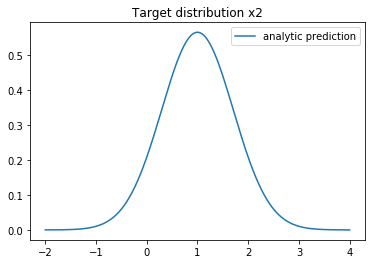

In [24]:
# Sampling the target distribution 
dx=0.001
x=-2
xVecPT=np.array([])
yVecPT=np.array([])
nm=0.
while(x<4):
    py=PT(np.array([[0],[x],[2]]),2)
    nm=nm+dx*py
    xVecPT=np.append(xVecPT,x)
    yVecPT=np.append(yVecPT,py)
    x=x+dx
yVecPT=yVecPT/nm
    
pyplot.plot(xVecPT,yVecPT,label='analytic prediction')
pyplot.title('Target distribution x2')
pyplot.legend()
plt.show()

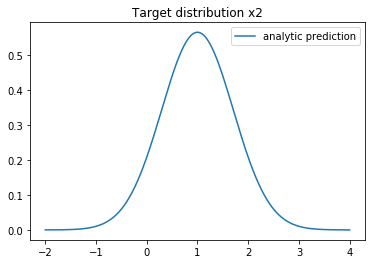

In [24]:
# target distribution 
dx=0.001
x=-2
xVecT=np.array([])
yVecT=np.array([])
nm=0.
while(x<4):
    py=Ptarg(np.array([[0]]),np.array([[x]]),np.array([[2]]),1,2)[0,0]
    nm=nm+dx*py
    xVecT=np.append(xVecT,x)
    yVecT=np.append(yVecT,py)
    x=x+dx
yVecT=yVecT/nm
    
pyplot.plot(xVecT,yVecT,label='analytic prediction')
pyplot.title('Target distribution x2')
pyplot.legend()
plt.show()

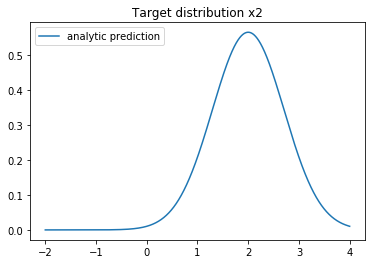

In [31]:
# target distribution 
dx=0.001
x=-2
xVecT=np.array([])
yVecT2=np.array([])
nm=0.
while(x<4):
    py=Ptarg(np.array([[1],[0],[0]]),np.array([[x],[0],[0]]),np.array([[3],[0],[0]]),2,3)[0,0]
    nm=nm+dx*py
    xVecT=np.append(xVecT,x)
    yVecT2=np.append(yVecT2,py)
    x=x+dx
yVecT2=yVecT2/nm
    
pyplot.plot(xVecT,yVecT2,label='analytic prediction')
pyplot.title('Target distribution x2')
pyplot.legend()
plt.show()

### 2.3 Sampling the prior distribution <a name="PriorSampling"></a>

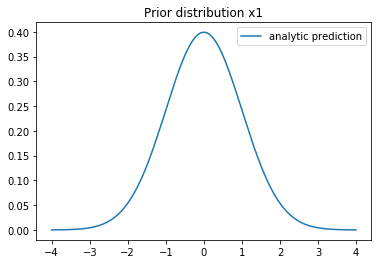

In [23]:
# Sampling the prior distribution 
dx=0.001
x=-4
xVecp0=np.array([])
yVecp0=np.array([])
nm=0.
while(x<4):
    py=prior_prob([x])
    nm=nm+dx*py
    xVecp0=np.append(xVecp0,x)
    yVecp0=np.append(yVecp0,py)
    x=x+dx
yVecp0=yVecp0/nm
    
pyplot.plot(xVecp0,yVecp0,label='analytic prediction')
pyplot.title('Prior distribution x1')
pyplot.legend()
plt.show()

## 3. Figure 7 (b) <a name="Figures"></a>

In [3]:
# Upload data

# CBMC Acceptance Rates
f = open("data/HC_CBMC_ACC_k1000_NT5.txt", "r")
r1000=np.array([])
K1000acc=np.array([])
for x in f:
    r1000=np.append(r1000, float(x[:2]))
    K1000acc=np.append(K1000acc, float(x[-6:]))
f.close()

f = open("data/HC_CBMC_ACC_k1000_NT10.txt", "r")
r1000_10=np.array([])
K1000acc_10=np.array([])
for x in f:
    r1000_10=np.append(r1000_10, float(x[:2]))
    K1000acc_10=np.append(K1000acc_10, float(x[-6:]))
f.close()

# tMC Acceptance Rates
Acc_dd_Vec_5 = np.load('data/HC_AlgoB_NMC=1000000_dxMax=4_n=10_Ntot=5_Acc_dd_Vec.npy',allow_pickle=True)
rB=np.array([])
Bacc=np.array([])
for i in range(int(len(Acc_dd_Vec_5)/2-1)):
    rB= np.append(rB,Acc_dd_Vec_5[2*i])
    Bacc= np.append(Bacc,Acc_dd_Vec_5[2*i+1])


Acc_dd_Vec_10 = np.load('data/HC_AlgoB_NMC=1000000_dxMax=4_n=10_Ntot=10_Acc_dd_Vec.npy',allow_pickle=True)
rB_10=np.array([])
Bacc_10=np.array([])
for i in range(int(len(Acc_dd_Vec_10)/2-1)):
    rB_10= np.append(rB_10,Acc_dd_Vec_10[2*i])
    Bacc_10= np.append(Bacc_10,Acc_dd_Vec_10[2*i+1])

    
# tMC Sampling positions monomers 1, 5, 9 for inset
x_1B = np.load('data/HC_AlgoB_NMC=1000000_dxMax=4_n=10_Ntot=10_x_1B.npy',allow_pickle=True)
x_5B = np.load('data/HC_AlgoB_NMC=1000000_dxMax=4_n=10_Ntot=10_x_5B.npy',allow_pickle=True)
x_9B = np.load('data/HC_AlgoB_NMC=1000000_dxMax=4_n=10_Ntot=10_x_9B.npy',allow_pickle=True)

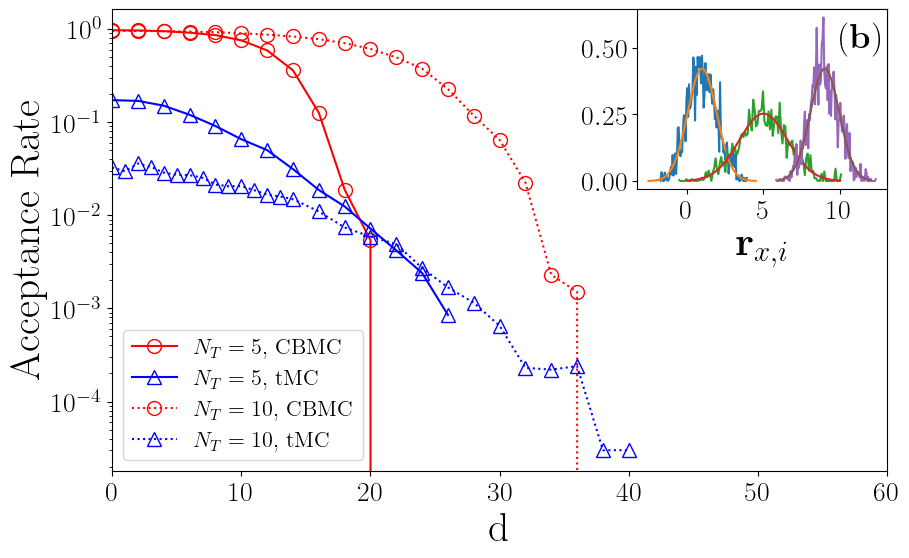

In [4]:
# Fig 7 (b)

#Inset
bins1=deepcopy(x_1B[1])
bins1= bins1 - (bins1[1]-bins1[0])/2
bins1=bins1[1:]

bins5=deepcopy(x_5B[1])
bins5= bins5 - (bins5[1]-bins5[0])/2
bins5=bins5[1:]

bins9=deepcopy(x_9B[1])
bins9= bins9 - (bins9[1]-bins9[0])/2
bins9=bins9[1:]

Ndis=500
# x_1B_a
xm=-2.5
xp=4.5
dx=(xp-xm)/Ndis
x=xm
x_1B_a=np.array([])
px_1B_a=np.array([])
while(x<=xp):
    x_1B_a=np.append(x_1B_a,x)
    px_1B_a=np.append(px_1B_a,gg(x,1))
    x=x+dx

xm=0.
xp=10.
dx=(xp-xm)/Ndis
x=xm
x_5B_a=np.array([])
px_5B_a=np.array([])
while(x<=xp):
    x_5B_a=np.append(x_5B_a,x)
    px_5B_a=np.append(px_5B_a,gg(x,5))
    x=x+dx

xm=6.
xp=12.
dx=(xp-xm)/Ndis
x=xm
x_9B_a=np.array([])
px_9B_a=np.array([])
while(x<=xp):
    x_9B_a=np.append(x_9B_a,x)
    px_9B_a=np.append(px_9B_a,gg(x,9))
    x=x+dx

fig, ax = plt.subplots(figsize=(10, 6))


ax.plot(r1000,K1000acc,linestyle = '-',marker='o',markersize=10, fillstyle='none', color ='r',label=r'$N_T=5$, CBMC')
ax.plot(rB,Bacc,linestyle = '-',marker='^',markersize=10, fillstyle='none', color ='b',label=r'$N_T=5$, tMC')

ax.plot(r1000_10,K1000acc_10,linestyle = ':',marker='o',markersize=10, fillstyle='none', color ='r',label=r'$N_T=10$, CBMC')
ax.plot(rB_10,Bacc_10,linestyle = ':',marker='^',markersize=10, fillstyle='none', color ='b',label=r'$N_T=10$, tMC')



ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('d',fontsize=30)
ax.set_ylabel('Acceptance Rate',fontsize=30)
ax.set_xlim(0.0,60)

pyplot.legend(fontsize=16,ncol=1,loc=3)

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.65, 0.58, 0.25, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])



ax2.set_xlabel(r'${\bf r}_{x,i}$',fontsize=30)
ax2.set_xticks(np.array([0,5,10]))
ax2.tick_params(axis='both', which='major', labelsize=20)

ax2.plot(bins1,x_1B[0])
ax2.plot(x_1B_a, px_1B_a)
ax2.plot(bins5,x_5B[0])
ax2.plot(x_5B_a, px_5B_a)
ax2.plot(bins9,x_9B[0])
ax2.plot(x_9B_a, px_9B_a)


ax2.text(10, 0.5, r'$(\mathrm{\bf b})$', fontsize=25)

plt.show()